In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV)

from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_gaussian_process
from skopt.space import Integer
from skopt.utils import use_named_args

In [2]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

y = y.map({0: 1, 1: 0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((398, 30), (171, 30))

In [4]:
# determine the hyperparameter response function

gbm = GradientBoostingClassifier(random_state=0)

param_grid = {'n_estimators': [10, 20, 50, 100, 120, 150, 200, 250, 300]}

search = GridSearchCV(gbm, param_grid, scoring='accuracy', cv=3, refit=False)

search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'n_estimators': [10, 20, 50, 100, 120, 150, 200, 250,
                                          300]},
             refit=False, scoring='accuracy')

In [5]:
results= pd.DataFrame(search.cv_results_)

results.sort_values(by='param_n_estimators', ascending=False, inplace=True)

results[['param_n_estimators', 'mean_test_score', 'std_test_score']]

,param_n_estimators,mean_test_score,std_test_score
8,300,0.952286,0.014111
7,250,0.952286,0.014111
6,200,0.952286,0.014111
5,150,0.949780,0.012687
4,120,0.949761,0.012736
3,100,0.947236,0.012280
2,50,0.942223,0.018721
1,20,0.934685,0.012722
0,10,0.937210,0.009236


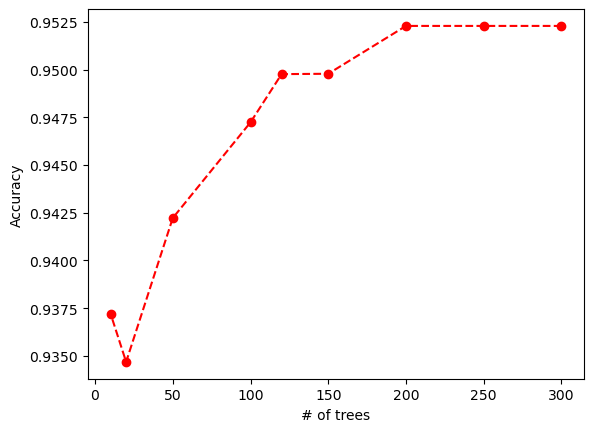

In [6]:
# accuracy vs # of estimators

plt.plot(results['param_n_estimators'], results['mean_test_score'], 'ro--')
plt.ylabel('Accuracy')
plt.xlabel('# of trees')

plt.show()

In [7]:
param_grid = [Integer(10, 300, name='n_estimators')]

In [8]:
param_grid

[Integer(low=10, high=300, prior='uniform', transform='identity')]

In [9]:
# define the objective function

@use_named_args(param_grid)
def objective(**params):
    gbm.set_params(**params)
    
    value = np.mean(
    cross_val_score(
        gbm,
        X_train,
        y_train,
        cv=3,
        n_jobs=-1,
        scoring='accuracy'
    )
    )
    
    return -value

In [11]:
# Bayesian Optimization

gp_ = gp_minimize(
    objective,
    param_grid,
    n_initial_points=2,
    acq_func='EI',
    n_calls=20,
    random_state=0
)

C:\ProgramData\anaconda3\envs\ml_env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\ProgramData\anaconda3\envs\ml_env\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


In [12]:
'Best score: %.4f' %gp_.fun

'Best score: -0.9523'

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

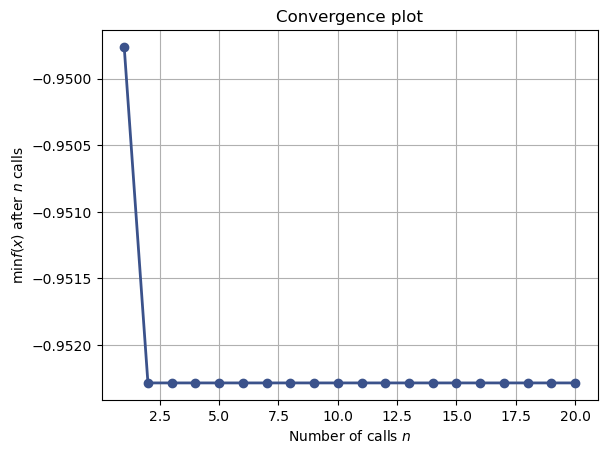

In [13]:
plot_convergence(gp_)

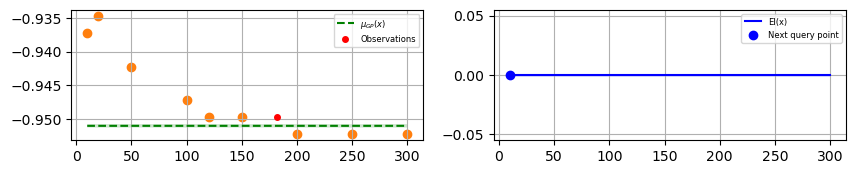

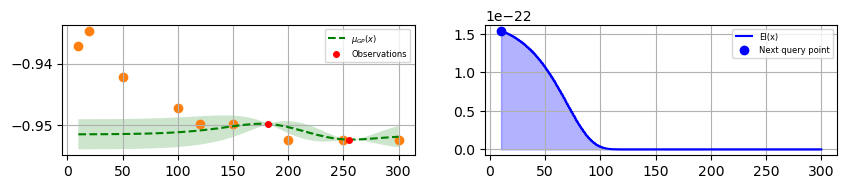

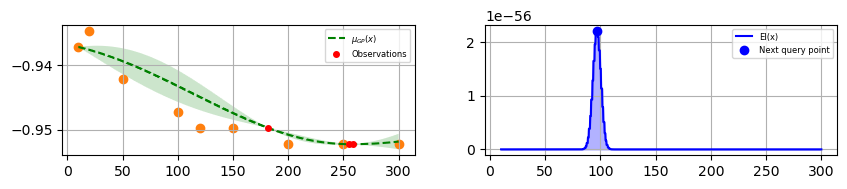

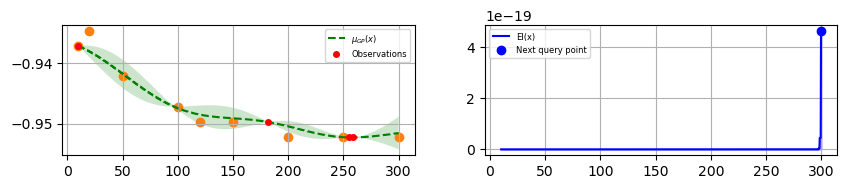

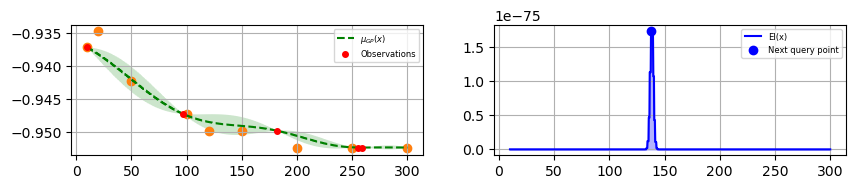

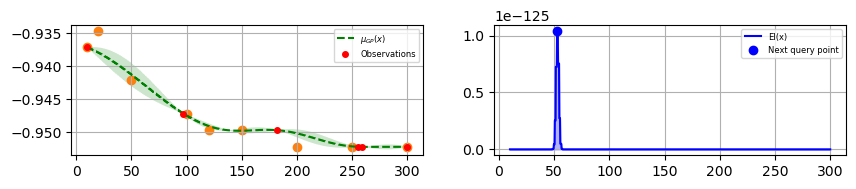

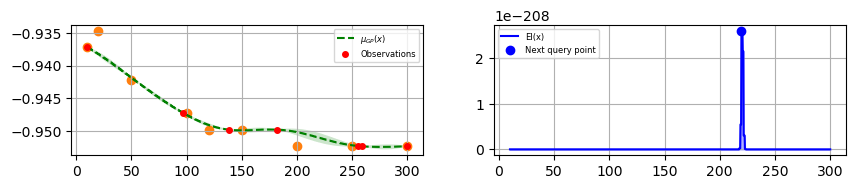

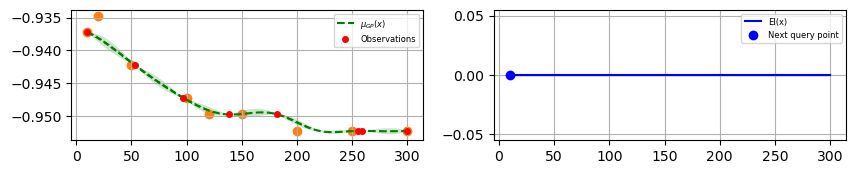

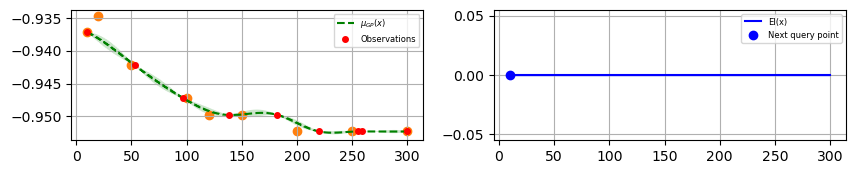

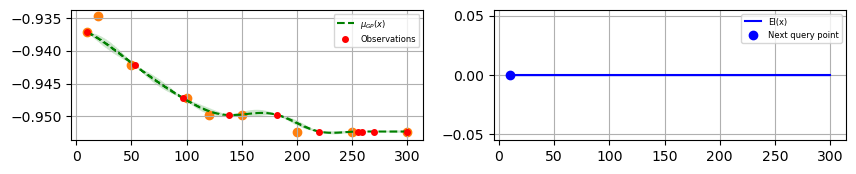

In [14]:
# plot bayesian optimization search

end = 10

for n_iter in range(end):
    
    plt.figure(figsize=(10, 20))
    plt.subplot(end, 2, 2*n_iter + 1)
    
    ax = plot_gaussian_process(
        gp_, n_calls=n_iter,
        show_legend=True,
        show_title=False,
        show_next_point=False,
        show_acq_func=False
    )
    
    ax.scatter(results['param_n_estimators'], -results['mean_test_score'])
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.subplot(end, 2, 2*n_iter + 2)
    
    ax = plot_gaussian_process(
        gp_, n_calls=n_iter,
        show_legend=True,
        show_title=False,
        show_mu=False,
        show_acq_func=True,
        show_observations=False,
        show_next_point=True
    )
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    
plt.show()